# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# EDA

In [2]:
df_sample_submission = pd.read_csv('./input/playground-series-s3e7/sample_submission.csv')
df_train = pd.read_csv('./input/playground-series-s3e7/train.csv', index_col='id')
df_test = pd.read_csv('./input/playground-series-s3e7/test.csv', index_col='id')

In [3]:
df_train.isna().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

##### There are no missing values in our data.

In [4]:
df_sample_submission.head()

,id,booking_status
0,42100,0.392
1,42101,0.392
2,42102,0.392
3,42103,0.392
4,42104,0.392


##### We are predicting the likelihood that a given booking will be cancelled.

In [5]:
df_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
id,,,,,,,,,,,,,,,,,,
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


##### All features are numeric, however some are still categorical like room_type_reserved which should be OneHot encoded.

In [6]:
df_train.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000
mean,1.920713,0.141093,0.884632,2.398005,0.239192,0.025249,0.428931,103.888029,2017.856295,7.593539,15.902945,0.728504,0.029192,0.019715,0.175772,104.566377,0.571734,0.392019
std,0.524950,0.450128,0.885693,1.427330,0.587674,0.156884,0.832605,81.069343,0.350795,2.829395,8.888582,0.633529,0.168347,0.325837,1.732121,37.139165,0.775041,0.488207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,93.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,155.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000,1.000000
max,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

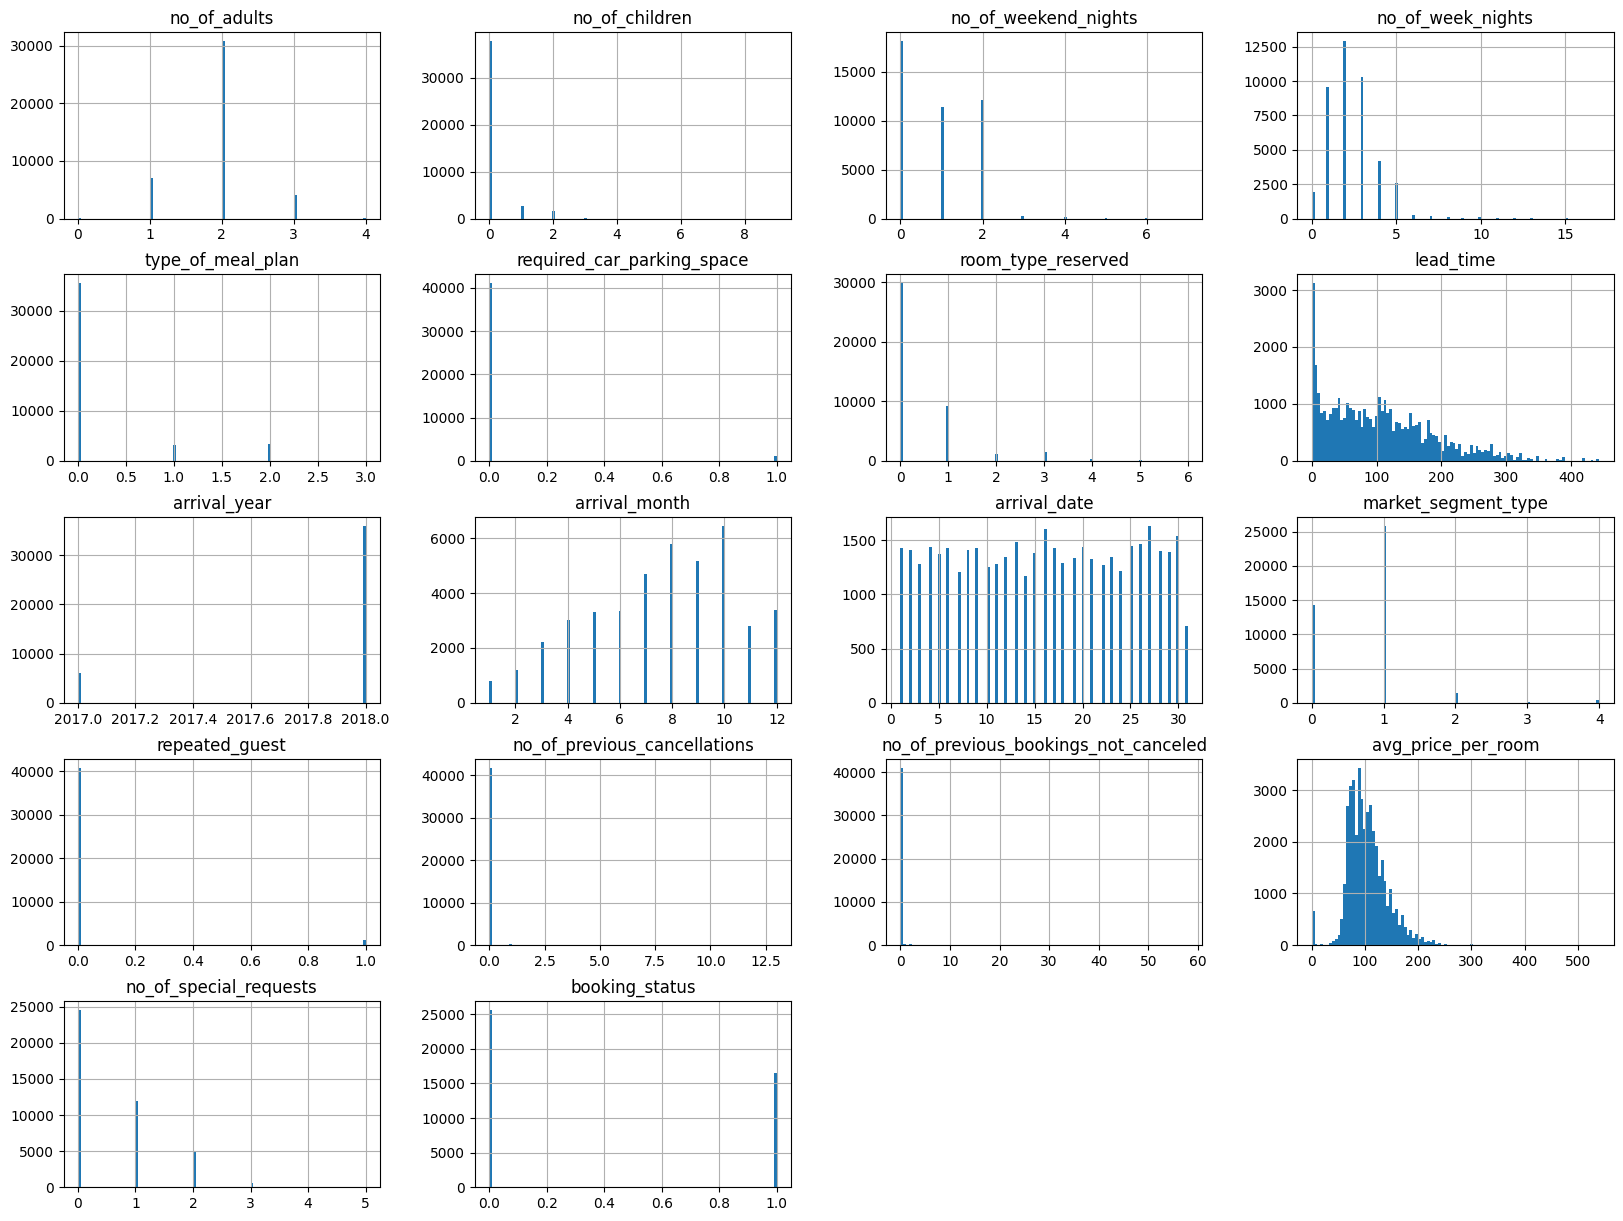

In [7]:
df_train.hist(bins=100, figsize=(20, 15))
plt.show

##### It appears that there are some outliers but from data context we can deduce that they are true outliers, some rooms will very expensive in the true population however they may not be representative of the underlying population, we may benefit from removing them.

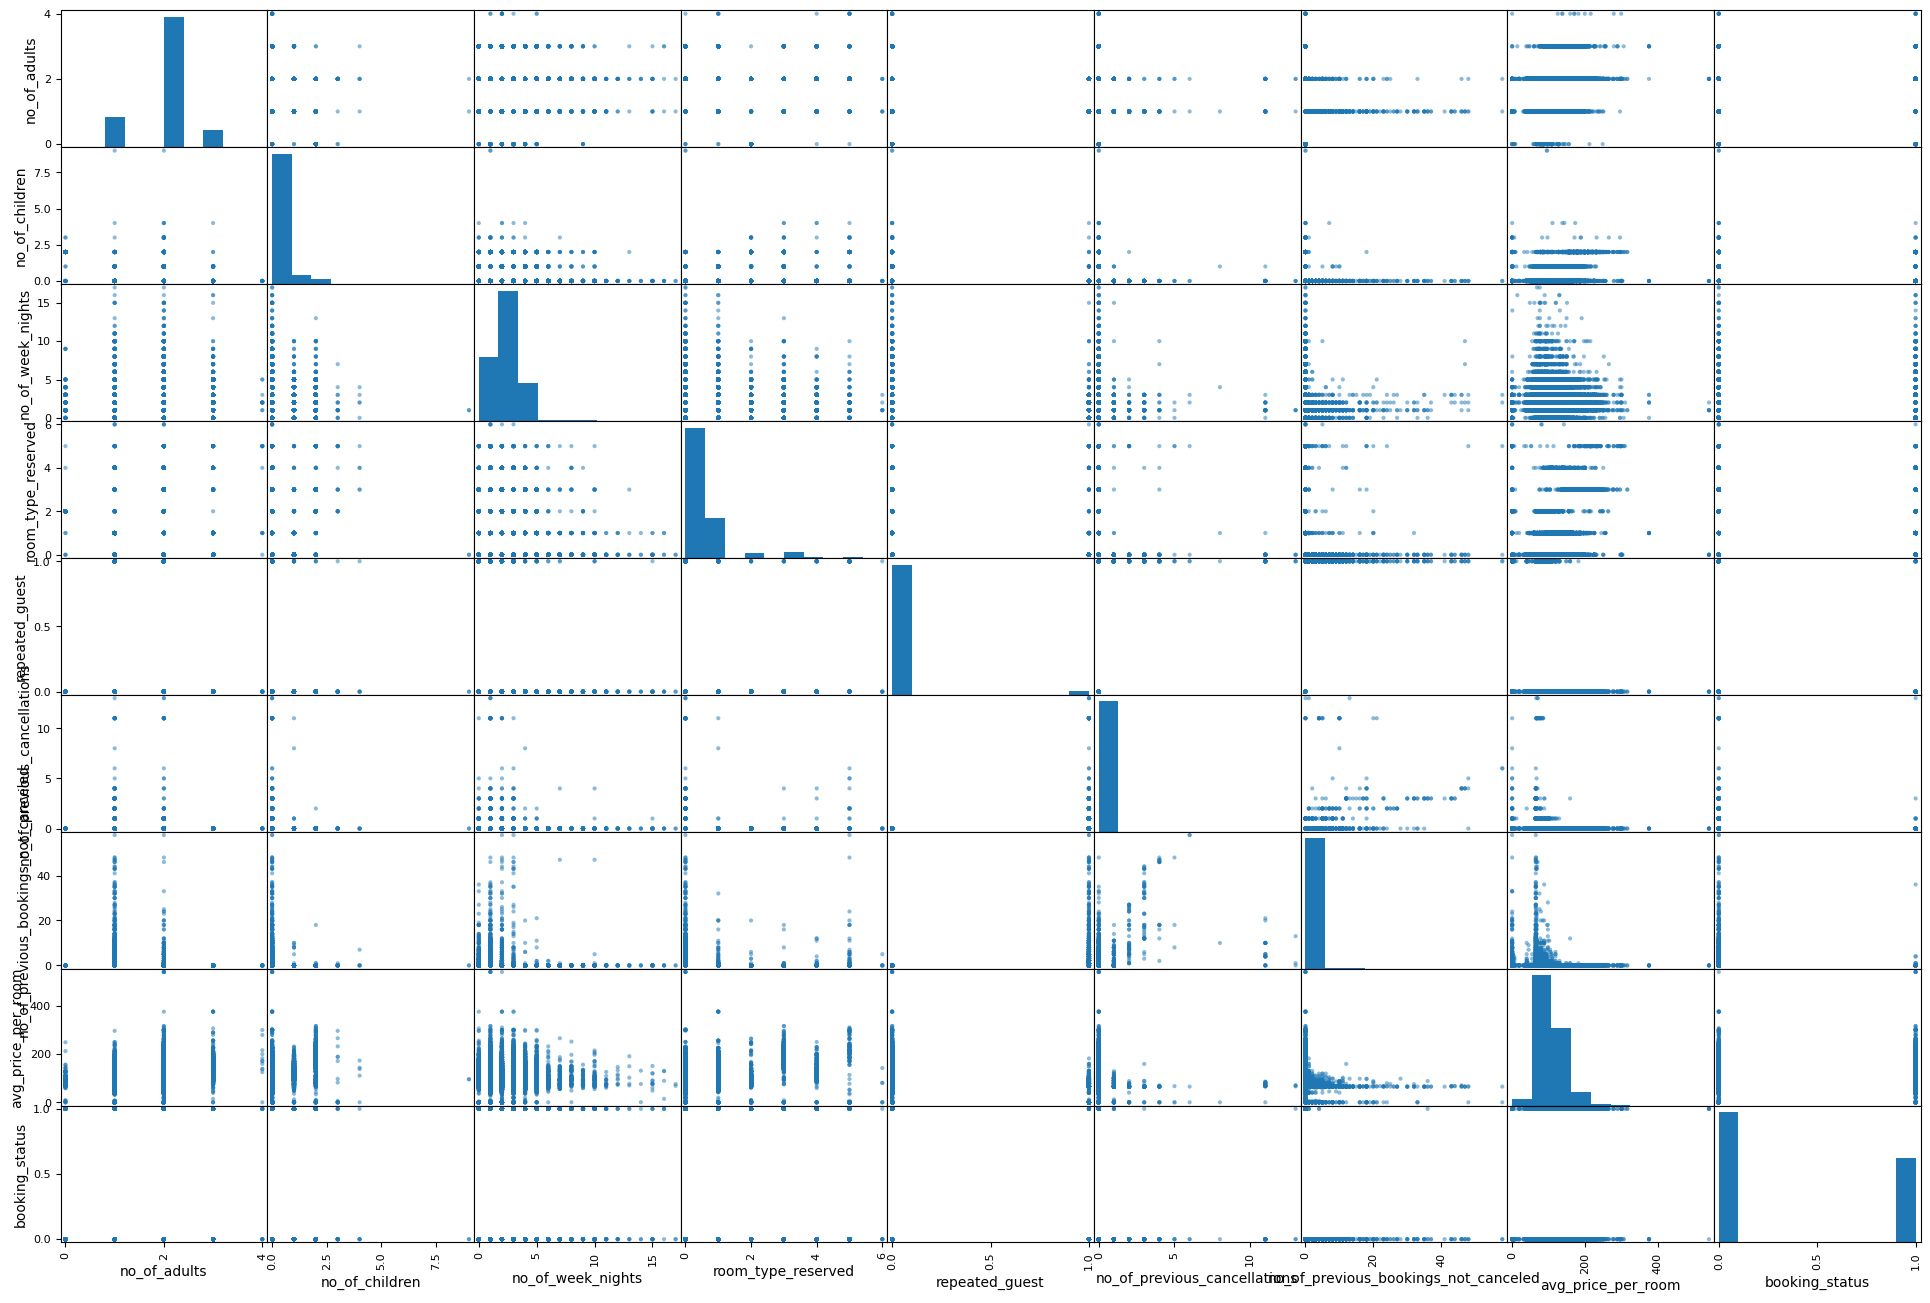

In [8]:
pd.plotting.scatter_matrix(df_train[['no_of_adults', 'no_of_children','no_of_week_nights',
                                     'room_type_reserved', 'repeated_guest','no_of_previous_cancellations',
                                     'no_of_previous_bookings_not_canceled','avg_price_per_room', 'booking_status']],
                           figsize=(24, 16))
plt.savefig(r"figure_1.png")
plt.show()

# Prep data from training

In [9]:
df_train = pd.read_csv('./input/playground-series-s3e7/train.csv', index_col='id')
df_test = pd.read_csv('./input/playground-series-s3e7/test.csv', index_col='id')

df_train = df_train.drop(['arrival_year'], axis=1)
df_test = df_test.drop(['arrival_year'], axis=1)

# Data Pipeline

In [10]:
features_for_normalization = df_train.drop(['booking_status', 'required_car_parking_space', 'repeated_guest'], axis=1).columns.tolist()

In [11]:
class HotelPipeline:

    def __init__(self):
        self.preprocessor = ColumnTransformer([
            ("num", StandardScaler(), features_for_normalization),
        ])
        self.model = xgb.XGBClassifier(n_estimators = 10000,
                                      learning_rate = 0.01,
                                      max_depth = 7,
                                      colsample_bytree = 0.7,
                                      gamma = 0.8,
                                      min_child_weight = 10,
                                      subsample = 0.7,
                                      early_stopping_rounds = 5
                                      )

    def _add_features(self, X):
        X['price_per_adult'] = X.no_of_adults / (X.avg_price_per_room + 1e-6)
        X['price_per_child'] = X.no_of_children / (X.avg_price_per_room + 1e-6)

    def fit(self, X, y, X_val, y_val):
        self._add_features(X)
        self._add_features(X_val)

        X = self.preprocessor.fit_transform(X)
        X_val = self.preprocessor.transform(X_val)

        self.model.fit(X, y, eval_set=[(X_val, y_val)], verbose=False)

    def predict(self, X):
        self._add_features(X)
        X = self.preprocessor.transform(X)
        y_pred = self.model.predict_proba(X)
        y_pred = y_pred[:, 1]
        return y_pred

    def grid_search(self, X, y, X_eval, y_eval):
        # Processes the data
        X = self.preprocessor.fit_transform(X)
        X_val = self.preprocessor.transform(X_eval)

        y = self.label_encoder.fit_transform(y.to_numpy().reshape(-1, 1))
        y_val = self.label_encoder.transform(y_eval.to_numpy().reshape(-1, 1))

        # Define the hyperparameters and their possible values
        param_grid = {
            'n_estimators': [10, 100, 1000],
            'max_depth': [3, 7, 11],
            'learning_rate':[0.1, 0.2],
            'subsample': [1, 10],
            'reg_lambda': [0, 1, 2],
            'reg_alpha': [0, 1, 2],
            'objective':['reg:squarederror'],
            'early_stopping_rounds':[5],
            'tree_method':["gpu_hist"]
        }

        # Create an XGBoost model and wrap it in a GridSearchCV object
        xgb_model = xgb.XGBRegressor()
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

        # Train the GridSearchCV object with early stopping
        grid_search.fit(X, y, eval_set=[(X_val, y_val)], verbose=False)

        print(grid_search.best_params_)

# Hyperparameter search

In [12]:
#X = df_train.drop('booking_status', axis=1)
#y = df_train['booking_status']
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
#CustomePipeline().grid_search(X_train, y_train, X_val, y_val)

# Train the model

In [13]:
X = df_train.drop(['booking_status'], axis=1)
y = df_train['booking_status']
SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
losses = []
pipelines = []
for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
    # splits data to dev/train sets and removes outliers from train data
    train_dataframe = df_train.iloc[idx_tr]
    dev_dataframe = df_train.iloc[idx_vl]

    # splits data to features and target
    X_train = train_dataframe.drop('booking_status', axis=1)
    y_train = train_dataframe['booking_status']
    X_dev = dev_dataframe.drop('booking_status', axis=1)
    y_dev = dev_dataframe['booking_status']

    # crates and fits a pipeline
    pipelineMy = HotelPipeline()
    pipelineMy.fit(X_train, y_train, X_dev, y_dev)

    # evaluates the model
    pipelines.append(pipelineMy)
    loss = roc_auc_score(y_dev, pipelineMy.predict(X_dev))
    losses.append(loss)
    print(f'Fold {fold} loss: {loss}')
print(f'Mean roc_auc_score: {np.array(losses).mean()}')

Fold 0 loss: 0.8954518903922603
Fold 1 loss: 0.9001838411570524
Fold 2 loss: 0.8971552218303315
Fold 3 loss: 0.8929243687921999
Fold 4 loss: 0.8923377109919348
Mean roc_auc_score: 0.8956106066327558


# Feature Importance

booster = pipelines[0].model.get_booster()
importance_scores = booster.get_score(importance_type='weight')

# Plot feature importance
fig, ax = plt.subplots()
xgb.plot_importance(booster, importance_type='weight', ax=ax)
ax.set_yticklabels(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
                    'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
                    'room_type_reserved', 'lead_time', 'arrival_month', 'arrival_date',
                    'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations',
                    'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
                    'no_of_special_requests'])
plt.show()

# Make Submission

In [14]:
def make_predictions(pipelines, data):
    prediction = []
    for pipeline in pipelines:
        prediction.append(pipeline.predict(data))
    return np.array(prediction).mean(axis = 0).ravel()

In [15]:
finale_predictions = make_predictions(pipelines, df_test)

In [16]:
submissions = pd.DataFrame({"id": list(range(42100, 42100 + len(finale_predictions))), "booking_status": finale_predictions})

In [17]:
pd.DataFrame(submissions).to_csv("submission.csv", index=False, header=True)